## Xây dựng mô hình hỗ trợ chẩn đoán bệnh tiểu đường với bộ dữ liệu sức khỏe Pima Indians Diabetes Database

Import các thư viện cần thiết

In [17]:
from mlxtend.plotting import plot_decision_regions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## OSEMN Pipeline
* O - Obtaining our data: Thu thập dữ liệu
* S - Scrubbing / Cleaning our data: Làm sạch dữ liệu
* E - Exploring / Visualizing our data will allow us to find patterns and trends: Khám phá dữ liệu
* M - Modeling our data will give us our predictive power as a wizard: Mô hình hóa
* N - Interpreting our data: Phân tích diễn giải kết quả

1. Thu thập dữ liệu

In [18]:
#Đọc dữ liệu từ file CSV
diabetes_data = pd.read_csv('d:\\downloads\\HS\\hetmon\\diabetes.csv')
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Bộ dữ liệu bao gồm :

-Biến phụ thuộc:
+ Outcome: bị tiểu đường hay không (biến nhị phân)

-Biến độc lập:
+ Pregnancies: đếm số lần mang thai (biến rời rạc)
+ Glucose: đường huyết (biến liên tục)
+ BloodPressure: huyết áp (biến liên tục)
+ SkinThickness: độ dày da (biến liên tục)
+ Insulin: nồng độ insulin (biến liên tục)
+ BMI: chỉ số khối cơ thể (biến liên tục)
+ DiabetesPedigreeFunction: chỉ số đánh giá nguy cơ di truyền dựa trên tiền sử gia đình (biến liên tục)
+ Age: Tuổi (biến rời rạc)

Nhận xét: Một số biến có giá trị bằng 0 bất hợp lý về mặt sinh học như Insulin, SkinThickness,...

2. Làm sạch dữ liệu

In [19]:
diabetes_data.info(verbose=True)
diabetes_data.describe().round(2).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.85,3.37,0.00,1.00,3.00,6.00,17.00
Glucose,768.0,120.89,31.97,0.00,99.00,117.00,140.25,199.00
BloodPressure,768.0,69.11,19.36,0.00,62.00,72.00,80.00,122.00
SkinThickness,768.0,20.54,15.95,0.00,0.00,23.00,32.00,99.00
Insulin,768.0,79.80,115.24,0.00,0.00,30.50,127.25,846.00
BMI,768.0,31.99,7.88,0.00,27.30,32.00,36.60,67.10
DiabetesPedigreeFunction,768.0,0.47,0.33,0.08,0.24,0.37,0.63,2.42
Age,768.0,33.24,11.76,21.00,24.00,29.00,41.00,81.00
Outcome,768.0,0.35,0.48,0.00,0.00,0.00,1.00,1.00


Nhận xét: 
- Các biến Glucose, BloodPressure, SkinThickness, Insulin hay BMI đều đang có giá trị 0, bất thường về mặt sinh học. Vì vậy coi đây là các giá trị missing.
- Thay thế bằng giá trị mean() với biến có phân bố gần chuẩn như Glucose và BloodPressure, giá trị median() với biến có phân bố lệch như SkinThickness, Insulin, BMI.

In [20]:
diabetes_data['Glucose'].replace(0, diabetes_data['Glucose'].mean(), inplace=True)
diabetes_data['BloodPressure'].replace(0, diabetes_data['BloodPressure'].mean(), inplace=True)
diabetes_data['SkinThickness'].replace(0, diabetes_data['SkinThickness'].median(), inplace=True)
diabetes_data['Insulin'].replace(0, diabetes_data['Insulin'].median(), inplace=True)
diabetes_data['BMI'].replace(0, diabetes_data['BMI'].median(), inplace=True)

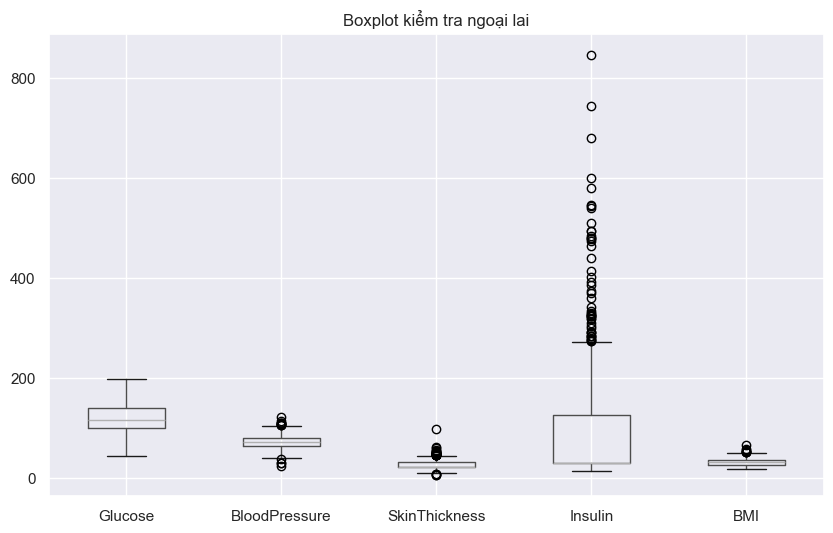

In [21]:
plt.figure(figsize=(10,6))
diabetes_data.boxplot(column=['Glucose','BloodPressure','SkinThickness','Insulin','BMI'])
plt.title("Boxplot kiểm tra ngoại lai")
plt.show()

Nhận xét: Còn tồn tại nhiều giá trị ngoại lai mạnh, đặc biệt như Insulin. Xử lý thay thế ngoại lai bằng các giá trị cận theo khoảng tứ phân vị IQR để giảm ảnh hưởng tới phân bố dữ liệu.

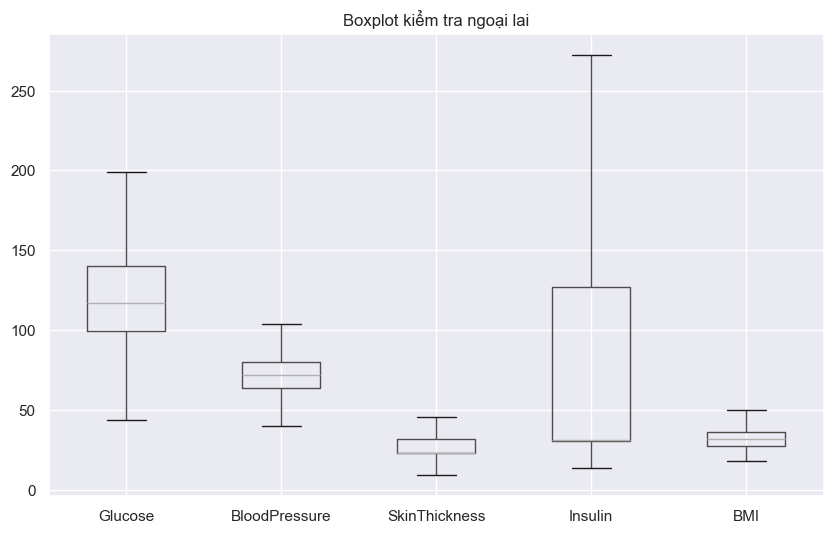

In [22]:
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in cols:
    Q1 = diabetes_data[col].quantile(0.25)
    Q3 = diabetes_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    diabetes_data[col] = np.where(
        diabetes_data[col] < lower_bound, lower_bound,
        np.where(diabetes_data[col] > upper_bound, upper_bound, diabetes_data[col])
    )

plt.figure(figsize=(10,6))
diabetes_data.boxplot(column=['Glucose','BloodPressure','SkinThickness','Insulin','BMI'])
plt.title("Boxplot kiểm tra ngoại lai")
plt.show()

3. Khám phá dữ liệu

In [23]:
diabetes_data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.85,3.37,0.00,1.00,3.00,6.00,17.00
Glucose,768.0,121.68,30.44,44.00,99.75,117.00,140.25,199.00
BloodPressure,768.0,72.23,11.72,40.00,64.00,72.00,80.00,104.00
SkinThickness,768.0,27.12,8.45,9.50,23.00,23.00,32.00,45.50
Insulin,768.0,86.14,76.29,14.00,30.50,31.25,127.25,272.38
BMI,768.0,32.39,6.67,18.20,27.50,32.00,36.60,50.25
DiabetesPedigreeFunction,768.0,0.47,0.33,0.08,0.24,0.37,0.63,2.42
Age,768.0,33.24,11.76,21.00,24.00,29.00,41.00,81.00
Outcome,768.0,0.35,0.48,0.00,0.00,0.00,1.00,1.00


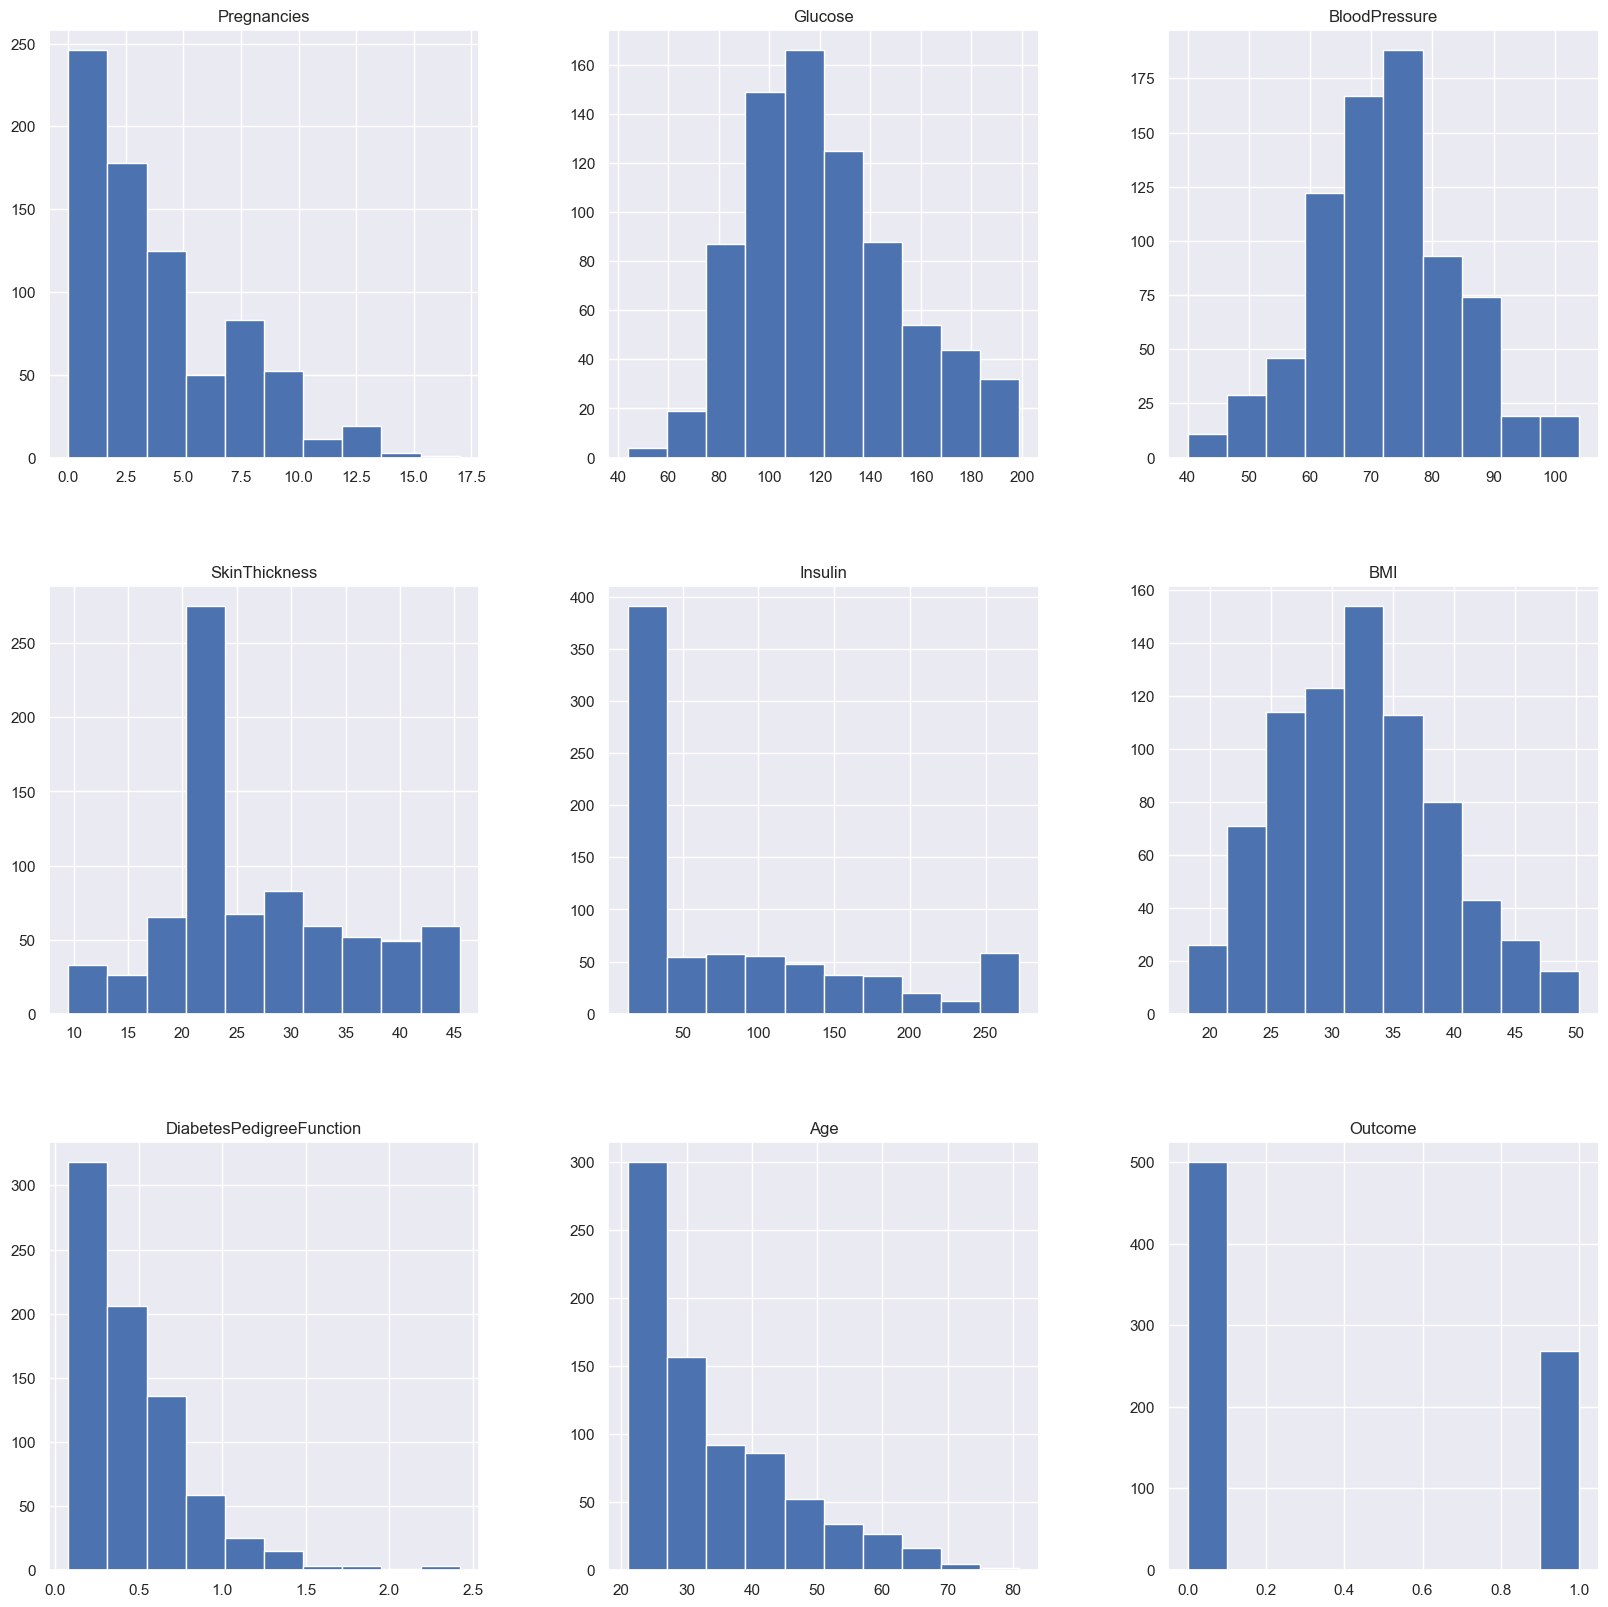

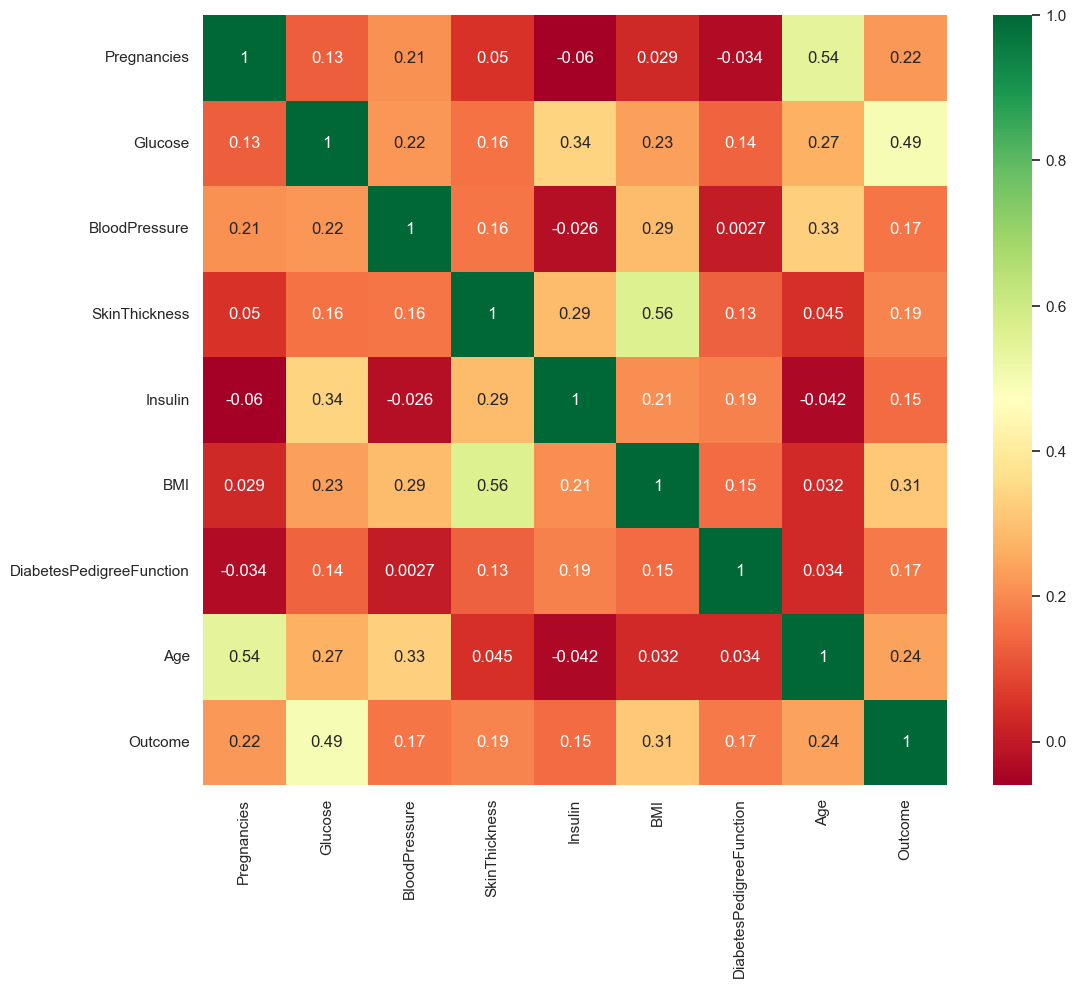

In [24]:
p = diabetes_data.hist(figsize = (20,20))
plt.figure(figsize=(12,10))
p = sns.heatmap(diabetes_data.corr(), annot=True,cmap ='RdYlGn')

Nhận xét: 
- Histogram: Quan sát biểu đồ tần suất cho thấy hầu hết các biến trong bộ dữ liệu có phân bố lệch phải, tức là tập trung nhiều ở giá trị thấp và kéo dài về phía giá trị cao.
Một số biến như Glucose và BloodPressure có dạng gần chuẩn, trong khi Insulin và SkinThickness lệch mạnh hơn và xuất hiện một số giá trị cực trị.
- Heatmap: Biểu đồ ma trận tương quan (heatmap) cho thấy mối quan hệ giữa các biến trong dữ liệu nhìn chung hợp lý về mặt sinh học. Glucose có tương quan mạnh nhất với Outcome, cho thấy đường huyết cao làm tăng nguy cơ tiểu đường. BMI cũng có tương quan dương với Outcome, phản ánh vai trò của thừa cân, béo phì. Ngoài ra, Age và Pregnancies có mối liên hệ rõ ràng, SkinThickness tương quan với BMI, và Glucose có quan hệ dương trung bình với Insulin.
Nhìn chung, các hệ số tương quan ở mức vừa phải, không có đa cộng tuyến đáng kể, tạo điều kiện thuận lợi cho quá trình mô hình hóa và huấn luyện sau này.


Chuẩn hóa trước khi huấn luyện mô hình

In [25]:
diabetes_data_drop = diabetes_data.drop("Outcome", axis = 1)
sc_X = StandardScaler()
X = pd.DataFrame(sc_X.fit_transform(diabetes_data_drop), columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
y = diabetes_data['Outcome']

4. Mô hình hóa

Chia tập train/test, chạy vòng lặp tìm k tốt nhất cho KNN

Max train score 100.0 % and k = [1]
Max test score 77.34375 % and k = [17]


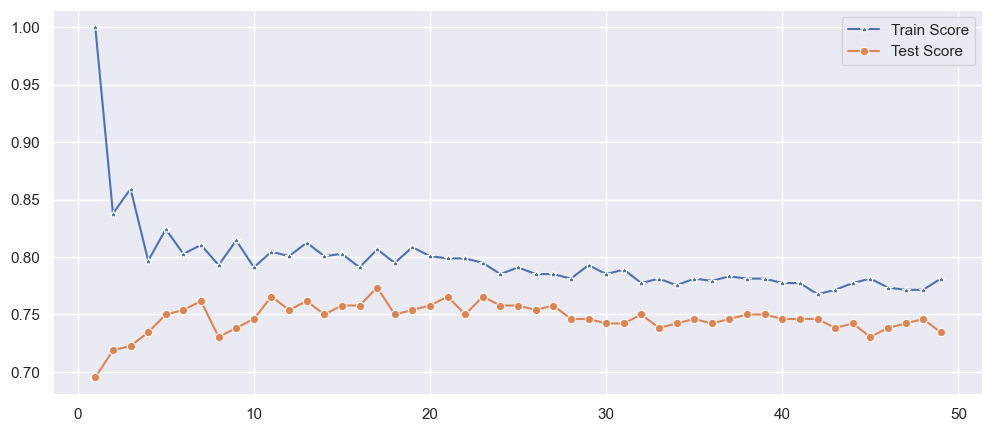

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

test_scores = []
train_scores = []
for i in range(1,50):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,50),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,50),y=test_scores,marker='o',label='Test Score')

Khởi tạo mô hình

In [27]:
knn = KNeighborsClassifier(17)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.7734375

5. Phiên giải

In [28]:
y_pred = knn.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,149,18,167
1,40,49,89
All,189,67,256


Nhận xét: Trong 256 mẫu, mô hình dự đoán đúng 149/167 ca âm tính và 49/89 ca dương tính, với 18 dương tính giả và 40 âm tính giả.
Mô hình có xu hướng dự đoán nghiêng về 0 nhưng vẫn nhận diện được phần lớn ca bệnh, phản ánh hiệu quả phân loại khá tốt và có thể cải thiện thêm qua tối ưu tham số hoặc cân bằng dữ liệu.

In [29]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       167
           1       0.73      0.55      0.63        89

    accuracy                           0.77       256
   macro avg       0.76      0.72      0.73       256
weighted avg       0.77      0.77      0.76       256



Nhận xét: Báo cáo cho thấy độ chính xác 77%, mô hình nhận diện 0 tốt hơn (precision 0.79, recall 0.89) so với 1 (precision 0.73, recall 0.55).
Điều này cho thấy mô hình còn bỏ sót một số ca bệnh, nhưng với F1-score 0.73, KNN (k=17) vẫn đạt hiệu năng ổn định và có thể cải thiện bằng cách cân bằng dữ liệu hoặc điều chỉnh ngưỡng phân loại.

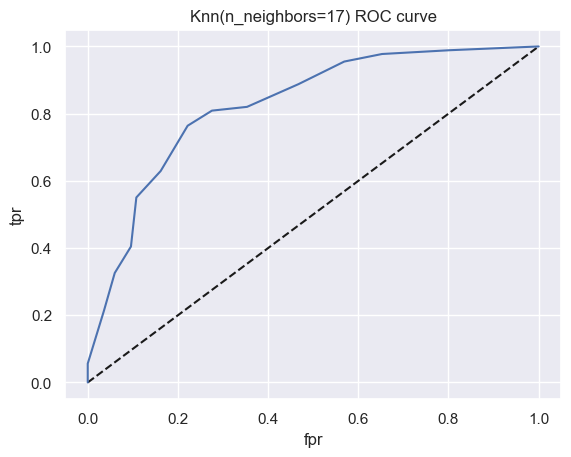

0.8250689631972011

In [30]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=17) ROC curve')
plt.show()
roc_auc_score(y_test,y_pred_proba)

Nhận xét: Đường cong ROC của mô hình KNN (k=17) cho thấy khả năng phân biệt hai lớp khá tốt, với đường cong nằm rõ ràng phía trên đường chéo ngẫu nhiên.
Giá trị TPR tăng nhanh khi FPR còn thấp, thể hiện mô hình nhận diện ca bệnh hiệu quả. Nhìn chung, KNN (k=17) đạt hiệu suất ổn định và có thể cải thiện thêm bằng cách tối ưu tham số hoặc điều chỉnh ngưỡng dự đoán để cân bằng giữa độ nhạy và độ đặc hiệu.

In [31]:
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5, return_train_score=True)
knn_cv.fit(X_train,y_train)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

results = pd.DataFrame(knn_cv.cv_results_)
train_scores = results['mean_train_score']
test_scores = results['mean_test_score']
k = results['param_n_neighbors']

print(f"Best train: {train_scores.max():.3f} at k={k[train_scores.idxmax()]}")
print(f"Best test:  {test_scores.max():.3f} at k={k[test_scores.idxmax()]}")

Best Score:0.7871501998857795
Best Parameters: {'n_neighbors': np.int64(12)}
Best train: 1.000 at k=1
Best test:  0.787 at k=12


Nhận xét: Ban đầu, mô hình KNN được huấn luyện thử nghiệm với k=17, đạt độ chính xác khoảng 77%.
Khi kiểm tra thêm bằng GridSearchCV, giá trị k=12 cho kết quả cao hơn nhẹ (78.7%).
Sự chênh lệch nhỏ này là do cách chia dữ liệu ngẫu nhiên, cho thấy KNN hoạt động ổn định và có khả năng tổng quát tốt với các giá trị k lân cận.

Logistic Regression: 73.83%
Decision Tree: 69.92%
Random Forest: 73.83%
SVM: 74.22%
KNN (k=17): 77.34%

=== BẢNG SO SÁNH HIỆU NĂNG CÁC MÔ HÌNH ===
                 Model  Accuracy  Precision  Recall  F1-score
0  Logistic Regression    0.7383     0.7315  0.7383    0.7329
1        Decision Tree    0.6992     0.6984  0.6992    0.6988
2        Random Forest    0.7383     0.7315  0.7383    0.7329
3                  SVM    0.7422     0.7341  0.7422    0.7332
4           KNN (k=17)    0.7734     0.7685  0.7734    0.7645


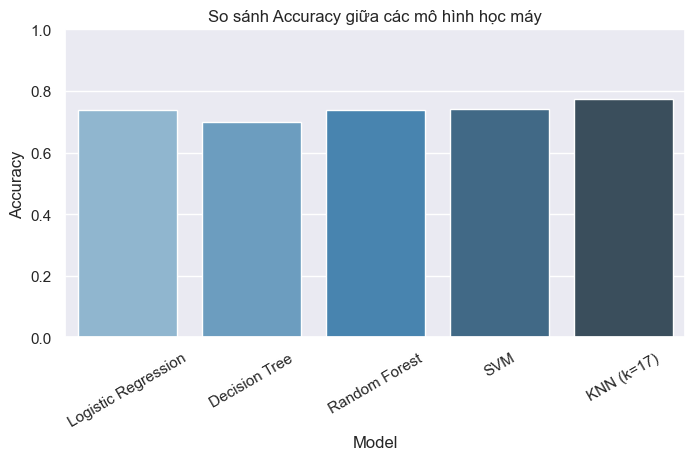

In [32]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(),
    'KNN (k=17)': KNeighborsClassifier(n_neighbors=17)
}

# --- Huấn luyện & đánh giá ---
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    })
    print(f'{name}: {acc*100:.2f}%')

# --- Bảng kết quả ---
df_results = pd.DataFrame(results)
print("\n=== BẢNG SO SÁNH HIỆU NĂNG CÁC MÔ HÌNH ===")
print(df_results.round(4))

# --- Biểu đồ ---
plt.figure(figsize=(8,4))
sns.barplot(data=df_results, x='Model', y='Accuracy', palette='Blues_d')
plt.title('So sánh Accuracy giữa các mô hình học máy')
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.show()

Nhận xét: Kết quả cho thấy KNN (k=17) đạt độ chính xác cao nhất 77.34%, vượt các mô hình khác như Logistic Regression, Random Forest, SVM và Decision Tree.
Xét theo Precision, Recall và F1-score, KNN cũng thể hiện hiệu năng cân bằng và ổn định, nên được chọn làm mô hình chính cho bài toán này.